# Example of how to derive conductances from SSUSI and use that in Lompe
This is a walkthrough of what is being done in the lompe.model.cmodel.Cmodel() class.

Start by importing relevant modules:

First import packages. I got dataloader function to work with the Iridium dataset with the following combination of packages and python version:  
python==3.7  
shapely.__version__==1.7.1  
astropy.__version__==4.2.1  


In [39]:
import numpy as np
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import apexpy
from scipy.ndimage import median_filter
from scipy.interpolate import RectBivariateSpline
import lompe
from lompe.data_tools import dataloader
from lompe.utils import sunlight, conductance

Select a date to work with. This script will assume that you are logged on the the BCSS dropbox account, where it will fetch the data. One excemption is the SuperMAG data. The new python-API should be implemented to download the data directly from the supermag server.


In [2]:
event = '2012-04-05'

Specify Dropbox path and path to where temp dataset files are stored. 

In [3]:
tempfile_path = './sample_dataset/'
basepath = tempfile_path + 'raw/'

Load the data and make the temp files

In [4]:
ampere     = pd.read_hdf(dataloader.read_iridium(event, basepath, tempfile_path))
superdarn  = pd.read_hdf(dataloader.read_sdarn(event, basepath, tempfile_path))
supermag   = pd.read_hdf(dataloader.read_smag(event, basepath, tempfile_path))
ssusi      = xr.load_dataset(dataloader.read_ssusi(event, basepath=basepath, tempfile_path=tempfile_path))

*read_ssusi()* will return the path to an array containing all SSUSI images located in *'basepath'* that are from the event date (.NC files from EDR_AURORA data downloaded from [the SSUSI homepage](https://ssusi.jhuapl.edu/https://ssusi.jhuapl.edu/) ). If we want to model a specific time, you can find the nearest image to the specified time:

In [20]:
sat = 'F18' # choose DMSP satellite to use image from
time = dt.datetime(int(event[0:4]), int(event[5:7]), int(event[8:10]), 21, 40)
DT = dt.timedelta(seconds = 5 * 60) # will select data from time +- DT

ssusi = ssusi.sel(date = (ssusi.satellite == sat))    
ssusi_i = ssusi.sel(date = time, method = 'nearest')  # closest in time ssusi image to use
print('SSUSI time: ' + np.datetime_as_string(ssusi_i.date.values, unit='s').replace('T',' ') + ' UT')

SSUSI time: 2012-04-05 21:34:14 UT


OR we could also select the time to model from which SSUSI images from the event date that are have available in *'basepath'*:

In [21]:
ii = 0 # select number of dmsp pass for condutance models
time = pd.to_datetime(ssusi['date'].values[ii])
DT = dt.timedelta(seconds = 5 * 60) # will select data from time +- DT

ssusi_i = ssusi.isel(date=ii)
print('SSUSI time: ' + np.datetime_as_string(ssusi_i.date.values, unit='s').replace('T',' ') + ' UT')

SSUSI time: 2012-04-05 21:34:14 UT


What is important is that you need one of the SSUSI images to calculate the conductance from precipitation later.

## Model grid

Set up model grid:

In [22]:
position = (-80, 82) # lon, lat
orientation = (-0.1, 1) # east, north
L, W, Lres, Wres = 10000e3, 6000e3, 100.e3, 100.e3 # dimensions and resolution of grid (L, Lres are along orientation vector)
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)

## Make the conductance model

1) First estimate condutance from EUV (solar) radiation. Construct with smaller weight to reduce impact where we have SSUSI coverage:

In [23]:
sza = sunlight.sza(grid.lat, grid.lon, time)       # solar zenith angle
EUV_hall, EUV_pedersen = conductance.EUV_conductance(sza, 100, 'hp', calibration = 'MoenBrekke1993')
# get on grid shape
EUV_hall = EUV_hall.reshape(grid.lon.shape)
EUV_pedersen = EUV_pedersen.reshape(grid.lon.shape)

2) Use SSUSI to estimate conductance from precipitation:

In [24]:
a = apexpy.Apex(time.year)

# SSUSI image on grid
glat, glon = a.convert(ssusi_i.mlat, ssusi_i.mlt, 'mlt', 'geo', height = 110, datetime = time)

# make median binned conductance image

# mask pixels missing data and pixels far away from grid
use = np.isfinite(ssusi_i['lbhs']) & grid.ingrid(glon, glat, ext_factor = 1.3)

index_i, index_j = grid.bin_index(glon[use], glat[use]) # i,j index in grid of each conductance observation
_index = grid._index(index_i, index_j)                  # correspoinding index in 1D format
df = pd.DataFrame({'_index':_index, 
                   'index_i':index_i, 
                   'index_j':index_j, 
                   'param':ssusi_i['lbhs'].values[use], 
                   'SH':ssusi_i['SH'].values[use], 
                   'SP':ssusi_i['SP'].values[use]})

Now, we make the gridded SSUSI LBHs counts into conductance using the Robinson formulae:

In [25]:
E0 = 1 # Estimate of the characteristic energy, to be applied in Robinson formulae.
counts_per_erg = 472. # 306 for lbhl. Need to be estimated from the image and region in question

# do statistics to estimate noise level
h, bb = np.histogram(df.param, bins = 30, range = [-400,500])
mode  = bb[np.argmax(h)]
df.loc[:,'param'] = df.loc[:,'param'] - 0.7*mode # 0.7 is quite arbitrarily chosen, but serves to avoid subtracting too much
df.loc[df['param'] < 0, 'param'] = 0
je = df['param'] / counts_per_erg # energy flux in mW/m2
            
# applying Robinson formulae (updates the data frame)
df.loc[:,'SP'] = (40. * E0 * np.sqrt(je)) / (16. + E0**2) # Pedersen conductance
df.loc[:,'SH'] = 0.45 * E0**0.85 * df.SP                  # Hall conductance

In [26]:
# make median binned average arrays, and populate cells without SSUSI pixels with a background value
_hall = df.groupby('_index').SH.median()
_pedersen = df.groupby('_index').SP.median()

binned_i, binned_j = grid._index2d(_pedersen.index)
binned_pedersen = np.zeros(grid.shape)
binned_pedersen[binned_i, binned_j] = _pedersen.values
nans = binned_pedersen == 0
binned_pedersen[nans] = np.median(binned_pedersen)


binned_i, binned_j = grid._index2d(_hall.index)
binned_hall = np.zeros(grid.shape)
binned_hall[binned_i, binned_j] = _hall.values
nans = binned_hall == 0
binned_hall[nans] = np.median(binned_hall)

# apply median filter on the binned average SSUSI image
binned_pedersen = median_filter(binned_pedersen, (2, 2))
binned_hall = median_filter(binned_hall, (2, 2))

In [ ]:
f_h = RectBivariateSpline(grid.eta[:,0], grid.xi[0,:], binned_pedersen, kx=3, ky=3, s=10)
eval_xi, eval_eta = grid.projection.geo2cube(lon, lat)

gridded = f(eval_eta, eval_xi, grid=False)

        nans = np.isnan(gridded)
        gridded[nans] = 0

The SSUSI data is binned on the model grid, and we do not need to interpolate the SSUSI image and derived conductances on a different grid. We add the EUV conductances to the SSUSI conductances.

In [27]:
# add the EUV conductance
SP_grd = binned_pedersen + EUV_pedersen
SH_grd = binned_hall + EUV_hall

## Electric field model (Lompe)

1) Prepare datasets

In [29]:
# prepare ampere
amp = ampere[(ampere.time >= time - DT) & (ampere.time <= time + DT)].dropna()
B = np.vstack((amp.B_e.values, amp.B_n.values, amp.B_r.values))
coords = np.vstack((amp.lon.values, amp.lat.values, amp.r.values))
amp_data = lompe.Data(B * 1e-9, coords, datatype = 'space_mag_full', scale = 200e-9)

# prepare supermag
sm = supermag[time-DT:time+DT].dropna()
B = np.vstack((sm.Be.values, sm.Bn.values, sm.Bu.values))
coords = np.vstack((sm.lon.values, sm.lat.values))
sm_data = lompe.Data(B * 1e-9, coords, datatype = 'ground_mag', scale = 100e-9)

# prepare superdarn
sd = superdarn.loc[(superdarn.index >= time - DT) & (superdarn.index <= time+ DT)].dropna()
vlos = sd['vlos'].values
coords = np.vstack((sd['glon'].values, sd['glat'].values))
los  = np.vstack((sd['le'].values, sd['ln'].values))
sd_data = lompe.Data(vlos, coordinates = coords, LOS = los, datatype = 'convection', scale = 500)

2) Initialize model and add datasets, and run inversion

In [42]:
emod = lompe.Emodel(grid, (SH_grd.flatten(), SP_grd.flatten()))
emod.add_data(amp_data, sm_data, sd_data)
emod.run_inversion(l1 = 2, l2 = 0)

TypeError: 'numpy.ndarray' object is not callable

4) Explore the conductance model result and compare to data

TypeError: Dimensions of C (18, 34) are incompatible with X (260) and/or Y (260); see help(pcolormesh)

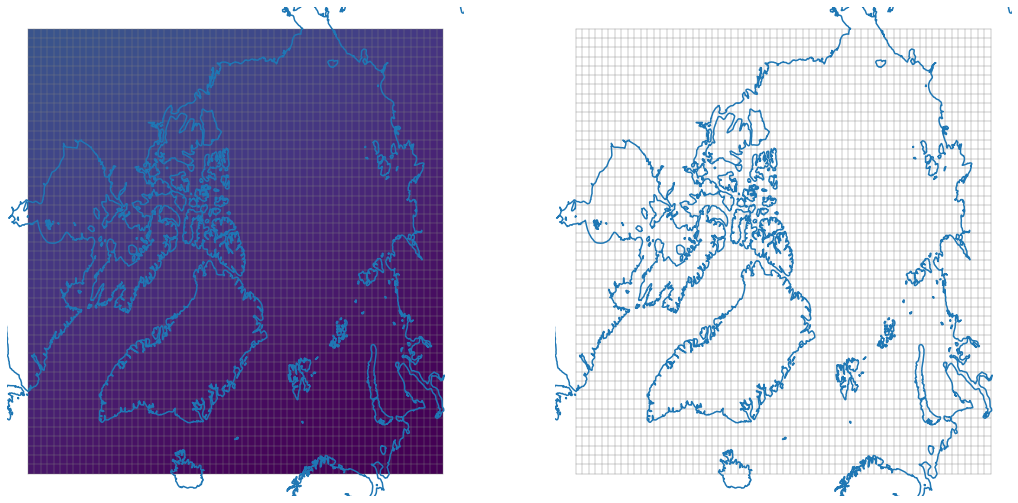

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (18, 9))

# Plot grid and coastlines:
for ax in axs:
    ax.set_axis_off()
    for lon, lat in grid.get_grid_boundaries():
        xi, eta = grid.projection.geo2cube(lon, lat)
        ax.plot(xi, eta, color = 'grey', linewidth = .4)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    for cl in grid.projection.get_projected_coastlines():
        ax.plot(cl[0], cl[1], color = 'C0')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#Plot ssusi on the projected map
#Reduce size of ssusi image to at least not exceed the CS grid face
__x = 30 #30
__y = 290 #300
axs[0].pcolormesh(grid.xi_mesh, grid.eta_mesh, EUV_hall, vmax=40, vmin=0)
xi, eta = grid.projection.geo2cube(glon, glat)
axs[0].pcolormesh(xi[__x:__y,__x:__y], eta[__x:__y,__x:__y], SH_grd[__x:__y,__x:__y], vmax=40, vmin=0)
axs[0].text(0.3, 0.99, 'Input data + EUV', transform = axs[0].transAxes)

# column vectors of model conductance:
hall_c = np.ravel(emod.hall_conductance()).reshape((-1, 1))
axs[1].pcolormesh(grid.xi_mesh, grid.eta_mesh, np.exp(hall_c.reshape(grid.lon_mesh.shape)), vmax=40, vmin=0)
axs[1].text(0.3, 0.99, 'Conductance inversion', transform = axs[1].transAxes)

Lompeplot

In [ ]:
lompe.lompeplot(emod, include_data = True, time = time, apex = a)